The harmonic potential is given by
\begin{equation}
    V(x) = \frac{1}{2}x^2.
\end{equation}
The harmonic oscillator wavefunctions are known and given by
\begin{equation}
    \psi_n(x) = \frac{C_n}{\pi^{1/4}} H_n(x) \exp\left(-\frac{x^2}{2}\right),
\end{equation}
where
\begin{align}
    &H_0 = 1, \quad &&C_0 = 1, \\
    &H_1 = 2x,  \quad &&C_1 = \frac{1}{\sqrt{2}}, \\
    &H_2 = 2(2x^2 - 1),  \quad &&C_2 = \frac{1}{2\sqrt{2}}, \\
    &H_3 = 4x(2x^2 - 3),  \quad &&C_3 = \frac{1}{4\sqrt{3}}, \\
    &H_4 = 4(4x^4 - 12x^2 + 3),  \quad &&C_4 = \frac{1}{8\sqrt{6}}, \\
    &H_5 = 8x(4x^4 - 20x^2 + 15), \quad &&C_5 = \frac{1}{16\sqrt{15}}, \\
    &H_6 = 8(8x^6 - 60x^4 + 90x^2 - 15), \quad &&C6 = \frac{1}{96\sqrt{5}}, \\
    &H_7 = 16x(8x^6 - 84x^4 + 210x^2 - 105), \quad &&C_7 = \frac{1}{96\sqrt{70}},
\end{align}
and so on.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class SchrodingerSolver:
    '''
    A solver for the 1D Schrödinger equation using the matrix method and Given's proceedure.
    '''
    def __init__(self, N, epsilon, potential_func):
        '''
        Initialise the solver with grid parameters and a potential function.
        Args:
            N: Half-number of grid points (total points = 2N).
            epsilon: Grid spacing.
            potential_func: A function V(x) that returns the potential.
        '''
        self.N = N
        self.epsilon = epsilon
        self.num_points = 2 * N

        # Discretise space
        self.x = np.linspace(-N * epsilon, N * epsilon, self.num_points, endpoint=False)

        # Diagonal elements
        self.V = potential_func(self.x)
        self.c = 1.0 + (epsilon**2) * self.V

        # Off-diagonal elements
        self.b_squared = 0.25

    def _count_eigenvalues_below(self, lam):
        '''
        Uses Given's Procedure to count eigenvalues < lambda, i.e., s(lambda).
        '''
        count = 0
        q = self.c[0] - lam

        if q < 0:
            count += 1

        for n in range(1, self.num_points):
            # Handling small q to avoid division by zero
            if abs(q) < 1e-12:
                q = 1e-12
            q = (self.c[n] - lam) - self.b_squared / q

            if q < 0:
                count += 1
        return count

    def find_eigenvalues(self, start_lambda=0.0):
        '''
        Finds the first four eigenvalues starting search from start_lambda.
        Returns a list of Energies (E), not matrix eigenvalues (lambda).
        '''
        energies = []
        current_lambda = start_lambda
        step_size = 0.5 * (self.epsilon**2)

        while len(energies) < 4:
            s_curr = self._count_eigenvalues_below(current_lambda)
            next_lambda = current_lambda + step_size
            s_next = self._count_eigenvalues_below(next_lambda)

            # If count increases, then an eigenvalue is crossed
            if s_next > s_curr:
                # Jumped over a state
                if s_next - s_curr > 1:
                    step_size /= 2
                    continue # Retry this step with smaller size

                # Refine with bisection
                lam_refined = self._bisect(current_lambda, next_lambda, s_curr)

                # Convert matrix lambda to energy E
                E = lam_refined / (self.epsilon**2)
                energies.append(E)

                # Move search forward
                current_lambda = lam_refined + (1e-4 * self.epsilon**2)
            else:
                current_lambda = next_lambda

            # Safety break for infinite loops
            if current_lambda > 100:
                print("Search limit exceeded.")
                break

        return np.array(energies)

    def _bisect(self, lower, upper, target_s_count):
        '''
        Bisection method to refine eigenvalue location.
        '''
        while upper - lower > 1e-12:
            mid = (lower + upper) / 2.0
            if self._count_eigenvalues_below(mid) > target_s_count:
                upper = mid
            else:
                lower = mid
        return (lower + upper) / 2.0

    def compute_eigenvector(self, E, state_index):
        '''
        Computes the eigenvector using symmetry to avoid tail divergence.
        '''
        psi = np.zeros(self.num_points)
        lam = (self.epsilon**2) * E

        # Integrate only from left boundary (n=0) to center (n=N)
        psi[0] = 1.0
        psi[1] = 2 * (self.c[0] - lam) * psi[0]

        # Stop at the center point x=0
        for n in range(1, self.N):
            psi[n+1] = 2 * (self.c[n] - lam) * psi[n] - psi[n-1]

            # Rescale to prevent overflow during calculation
            if abs(psi[n+1]) > 1e10:
                psi[:n+2] /= np.max(np.abs(psi[:n+2]))

        # Mirror the result to the right side around the center index N
        parity = 1 if (state_index % 2 == 0) else -1
        for k in range(1, self.N):
            if self.N + k < self.num_points:
                psi[self.N + k] = parity * psi[self.N - k]

        # Normalise
        norm = np.sqrt(np.sum(psi**2) * self.epsilon)
        psi = psi / norm

        # Convention: The main lobe on the right side (x > 0) is positive.
        right_half = psi[self.N:]
        # If the main feature on the right is negative, flip the whole wavefunction
        max_val_right = right_half[np.argmax(np.abs(right_half))]
        if max_val_right < 0:
            psi *= -1.0

        return psi

def plot_quantum_states(x, V, energies, wavefunctions):
    '''
    Plots the energy levels and shifted wavefunctions.
    '''
    plt.figure(figsize=(8, 5))
    for i, (E, psi) in enumerate(zip(energies, wavefunctions)):
        plt.plot(x, psi + E, label=f"n={i}, E={E:.3f}")
    plt.title(f"Numeric Bound States")
    plt.xlabel("Position $x$")
    plt.ylabel("Wavefunction $\\psi(x)$")
    plt.ylim(0, np.max(wavefunctions) + np.max(energies))
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

def find_states_and_plot(potential, N_in=50, eps_in=0.1, lam_start=0.0):
    '''
    Finds the first four states and plots them.
    '''
    solutions = SchrodingerSolver(N=N_in, epsilon=eps_in, potential_func=potential)
    energies = solutions.find_eigenvalues(start_lambda=lam_start)
    eigenvectors = [solutions.compute_eigenvector(E, i) for i, E in enumerate(energies)]
    plot_quantum_states(solutions.x, solutions.V, energies, eigenvectors)
    return solutions, energies, eigenvectors

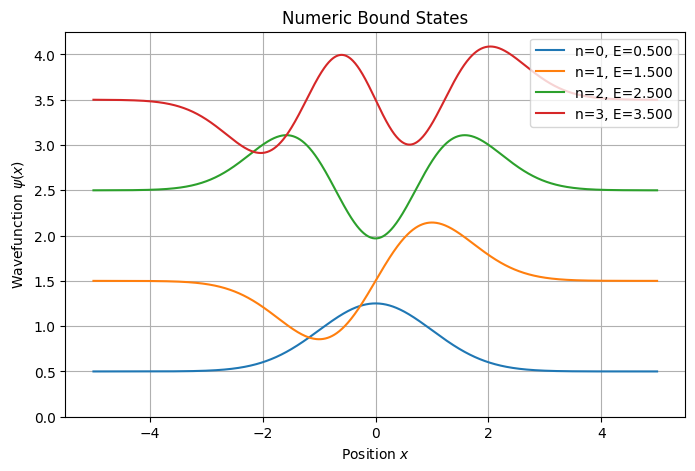

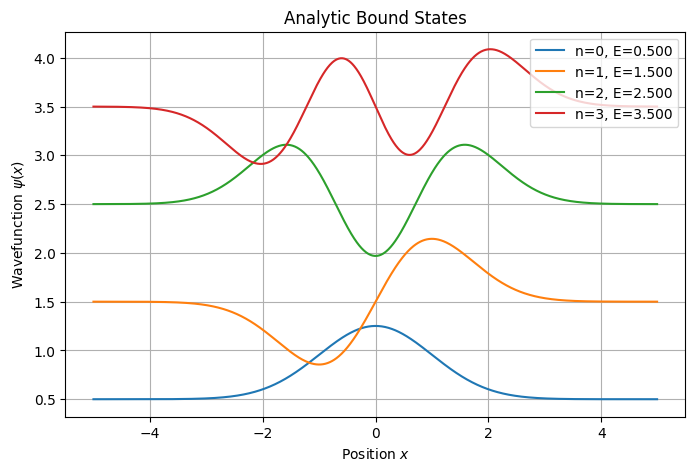


n | E_diff   | psi_diff
-------------------------
0 | 0.000003 | 0.000003
1 | 0.000016 | 0.000018
2 | 0.000041 | 0.000089
3 | 0.000077 | 0.000349


In [ ]:
def harmonic_potential(x):
    return 0.5 * x**2

def get_analytic_solution(n, x):
    '''
    Returns the exact energy and wavefunction for the harmonic oscillator
    for state n at positions x.
    '''
    E_exact = n + 0.5
    pi_term = np.pi**(-0.25)
    exp_term = np.exp(-0.5 * x**2)
    if n == 0:
        psi_exact = pi_term * exp_term
    elif n == 1:
        psi_exact = pi_term * np.sqrt(2) * x * exp_term
    elif n == 2:
        psi_exact = pi_term * (1.0/np.sqrt(2)) * (2*x**2 - 1) * exp_term
    elif n == 3:
        psi_exact = pi_term * (1.0/np.sqrt(3)) * (2*x**3 - 3*x) * exp_term
    return E_exact, psi_exact

solutions, energies, wavefunctions = find_states_and_plot(harmonic_potential, N_in=500, eps_in=0.01, lam_start=0.0)
numeric_energies, numeric_wavefunctions = zip(*[(E, psi) for E, psi in zip(energies, wavefunctions)])
analytic_energies, analytic_wavefunctions = zip(*[get_analytic_solution(n, solutions.x) for n in range(4)])

plt.figure(figsize=(8, 5))
for n in range(4):
    E_exact, psi_exact = get_analytic_solution(n, solutions.x)
    plt.plot(solutions.x, psi_exact + E_exact, label=f"n={n}, E={E_exact:.3f}")
plt.title(f"Analytic Bound States")
plt.xlabel("Position $x$")
plt.ylabel("Wavefunction $\\psi(x)$")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print(f"\nn | {"E_diff"}   | {"psi_diff"}")
print("-" * 25)
for n in range(4):
    E_diff = np.abs(numeric_energies[n] - analytic_energies[n])
    psi_diff = np.max(np.abs(numeric_wavefunctions[n] - analytic_wavefunctions[n]))
    print(f"{n} | {E_diff:.6f} | {psi_diff:.6f}")

The parameter $\epsilon$ determines the accuracy of the finite difference approximation for the second derivative. The Schrödinger equation involves a second derivative which was approximated using the central difference formula
\begin{equation}
    \psi''(x) \approx \frac{\psi(x+\epsilon) - 2\psi(x) + \psi(x-\epsilon)}{\epsilon^2}.
\end{equation}
If we perform a Taylor series expansion, we get after rearrangment
\begin{equation}
    \psi''(x) = \frac{\psi(x+\epsilon) - 2\psi(x) + \psi(x-\epsilon)}{\epsilon^2} + O(\epsilon^2).
\end{equation}
This shows that the truncation error of the method scales with $O(\epsilon^2)$. From this, we see that $\epsilon$ must be taken small enough to ensure the cumulative error over $2N$ steps remains low. However, if $\epsilon$ is too small then division by $\epsilon^2$ in the matrix term causes floating-point errors to accumulate and explode.

The product $L = N\epsilon$ determines the physical size of the box $[-L, +L]$. The boundary condition enforced by the matrix method is $\psi(\pm L) = 0$, i.e., an infinite square well. If $N\epsilon$ is too small, then we artificially squeeze the wavefunction, which increases its curvature and shifts the calculated energy $E$ higher than the true value. Typically, we need $N\epsilon$ to be significantly larger than the turning point to capture the exponential tail.

The function $s(\lambda)$ is a step function that increases by an integer exactly when $\lambda$ crosses an eigenvalue $E_n$. To find all eigenvalues, the step size $\Delta \lambda$ must be smaller than the separation between adjacent eigenvalues
\begin{equation}
    \Delta \lambda < E_{n+1} - E_n.
\end{equation}
This step size can be found depending on $\epsilon$. Once the interval is found, the bisection method is used with a high precision to ensure we trap the eigenvalue in an interval with appropriate accuracy.